In [2]:
# lecture 3

# previous lecture's model was weak
# but if we scale up the bigram model table
# the number of elements in the matrix grows exponentially
# elements = vocab_size^context_len

In [3]:
# We will follow the MLP LM from Bengio el al 2003
# "A neural Probabilisitc Language Model"

# we are building a character level language model
# we will stick with characters but take the same modeling approach

# To each word, embed it into a 30-dimensional feature vector
# The paper has 17,000 words in 30-dimensional space
# Embeddings get tuned using backpropagation to get semantic orientation

# To train the network, maximize the log-likelihood of the training data
# under the model

# 3 previous words are used to predict the fourth word in a sequence

# using the index of the word, the embedding is fed into the model
# by indexing into the embedding matrix C (equivalent to multiplying C
# with a one-hot vector of the index) 
# 00010 @ C --> fourth row of C <==> C[3]

# output layer is a probability distribution over vocab_size
# Use it to find the likelihood of the one-hot encoded true next word

In [266]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [267]:
# build the vocabulary of characters and mappings to/from integers
with open('./data/names.txt', 'r') as f:
    words = f.read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}


In [3]:
block_size = 3 # context length
X, Y = [], []
for w in words:
    #print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # crop and append
X=torch.tensor(X); Y=torch.tensor(Y)

In [7]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
# let's build the embedding matrix C
# paper has 17000 words embedded into 30 dims
# we have 27 chars, so we'll embed them in 2d space

C = torch.randn((27,2))

In [9]:
assert torch.equal(
    C[5], F.one_hot(torch.tensor(5), num_classes=27).float() @ C
)
# we can think of indexing as equivalently as the first 'layer'
# of the neural net, where the layer is just a linear projection
# of the index in to embedding space without an activation 

In [10]:
# simultaneously embed an entire batch
assert torch.allclose(C[X[torch.arange(32)]], C[X])
# C[X[torch.arange(32)]) indexes C for every example in the X batch
# C[X] also does this
batch_embeddings = C[X]
X.shape, batch_embeddings.shape

(torch.Size([32, 3]), torch.Size([32, 3, 2]))

In [11]:
# let's construct the neural network

W1 = torch.randn((6,100))
b1 = torch.randn(100)

# flatten the 2-dimensional embedding
Z1 = batch_embeddings.flatten(-2) @ W1 + b1
Z1.shape

emb = batch_embeddings
# or we could flatten the embeddings the long way
# we have a batch of 3x2 examples
# we could concatenate the last dimension into the middle dim
assert torch.equal(emb.flatten(-2), 
                      torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), dim=1)
                     )

# emb is a 32, 3, 2 tensor
# 32 examples in the batch
# each example is size 3x2
# this means that each example is made up of 3 2-dimensional embeddings
# in order to flatten each example for input to the nn:
# we need to concatenate the 2-dimensional embeddings and arrange them along the first dim
# ie for every example in the batch
    # for every embedding in the example
        # concatenate all embeddings

# alternatively:
torch.cat(torch.unbind(emb, 1), 1)
                                                  
                                                  

In [26]:
# a better way
a = torch.arange(18)
print(a.shape)
print(a.view(3, 3, 2).shape)

# tensors are represented as 1d vectors in memory, with dimensions stored separately
#print(a.storage())

# the significance of this is in-place reshaping operations are very efficient:
# they need only modify the dimension attributes, rather than creating new tensors in memory

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h.shape)

# check broadcasting
# emb.shape = 32, 6
# W1.shape  = 6, 100
# so (emb @ W1).shape = 32, 100
# and we need to add to the bias with shape (100)

# 6 100
# 100 
# gets broadcasted (aligning on the right) as 
# 6 100
# 1 100#


torch.Size([18])
torch.Size([3, 3, 2])
torch.Size([32, 100])


In [28]:
# final layer

W2 = torch.randn((100, 27))
b2 = torch.randn((27))

logits = h @ W2 + b2

In [37]:
counts = logits.exp()
probs  = counts / counts.sum(dim=1, keepdims=True)

print(counts.shape)
print(counts.sum(dim=1, keepdims=True).shape)

assert torch.allclose(F.softmax(logits, dim=1), probs)

# why do we have to do keepdims=True for the manual softmax calculation?
# counts.shape = (32, 27)
# without keepdims: 32, 27
#                   32
# ie without doing keepdims, counts.sum(dim=1).shape=32
# doing keepdims makes the broadcasting work bc .shape=(32, 1)


torch.Size([32, 27])
torch.Size([32, 1])


In [65]:
# find the log-likelihood

Y.shape, probs.shape
likelihoods = probs[torch.arange(Y.shape[0]), Y]

# or equivalently, elementwise multiply the one-hot encoded labels with probs

y_one_hot = F.one_hot(Y, num_classes=27).float()

assert torch.equal((probs * y_one_hot).sum(dim=1), probs[torch.arange(probs.shape[0]), Y])

log_likelihood = torch.sum(likelihoods.log())
loss = -log_likelihood
loss

tensor(107.3899)

In [282]:
## cleaned up version of initialization ##
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 10, generator=g) # embedding matrix
W1 = torch.randn(30, 200, generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn(200, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

11897


In [134]:
emb = C[X] # get embeddings based on X
z = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = z @ W2 + b2

counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
log_likelihood = probs[torch.arange(probs.shape[0]), Y].log().mean()
print(-log_likelihood)
print(negative_log_likelihood_ce)

# equivalently,
negative_log_likelihood_ce = F.cross_entropy(logits, Y)
assert abs(negative_log_likelihood_ce - -log_likelihood) < 0.001

tensor(19.5052)
tensor(17.7697)


In [118]:
# why we use cross entropy rather than manually calculating log-likelihood (aside from ease of use)
# efficiency (fused kernels, simplified expressions, etc)
# extreme value handling.. consider example below

# very negative extreme logit value
logits = torch.tensor([-100, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
print(f'probs with a very negative value: {probs}')
print('^^ well behaved')
# this is ok bc e^-<high number> just approaches 0

# very positive extreme logit value
logits = torch.tensor([100, -3, 0, 5])
counts = logits.exp() # e^100 is a problem -- pytorch represents it as inf
probs = counts / counts.sum() # division by infinity 
print(f'probs with a very positive value: {probs}')
print("^^ not well behaved")

# F.cross entropy takes care of the high values by subtracting the max value
logits = torch.tensor([100, -3, 0, 5])
logits_offset = logits - logits.max()
counts = logits_offset.exp()
probs = counts / counts.sum()
print(f'probs (from offset logits): {probs}')
print("^^ well behaved")

probs with a very negative value: tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])
^^ well behaved
probs with a very positive value: tensor([nan, 0., 0., 0.])
^^ not well behaved
probs (from offset logits): tensor([1.0000e+00, 1.4013e-45, 3.7835e-44, 5.5211e-42])
^^ well behaved


In [9]:
### --------- Training ------------ ###

print(X.shape)

for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # forward pass
    assert torch.allclose(F.one_hot(X, num_classes=27).float() @ C, C[X])
    emb = C[X]
    h1 = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h1 @ W2 + b2
    nll = F.cross_entropy(logits, Y) # mean reduction by default
    print(nll.item())
    # backward pass
    for p in parameters:
        p.grad = None  
        
    nll.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad
        


torch.Size([228146, 3])
10.709585189819336
10.407631874084473
10.127808570861816
9.864364624023438
9.61450481414795
9.37644100189209
9.148946762084961
8.931112289428711
8.722232818603516
8.52175235748291


In [283]:
lri = []
stepi = []
lossi = []

In [298]:
### Modify the training loop for minibatches ###

#1 randomly select some portion of the dataset ("minibatch")
#2 forward/backward/update using that minibatch
#3 get a new minibatch for next iteration of trianing
# then similar code as full gradient descent

# minibatch size is a tradeoff btwn gradient accuracy and 
# number of steps

for p in parameters:
    p.requires_grad = True

batch_size = 32
for i in range(200000):
    # minibatch selection
    indices = torch.randint(0, Xtr.shape[0], (batch_size,))
    X_batch = Xtr[indices]
    Y_batch = Ytr[indices]
    
    # forward pass
    #assert torch.allclose(F.one_hot(X, num_classes=27).float() @ C, C[X])
    emb = C[X_batch]
    h1 = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h1 @ W2 + b2
    nll = F.cross_entropy(logits, Y_batch) # mean reduction by default
    # backward pass
    for p in parameters:
        p.grad = None  
        
    nll.backward()
    
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(nll.log10().item())
    lri.append(lr)
    stepi.append(i)
    
print(nll.item())


2.3522260189056396


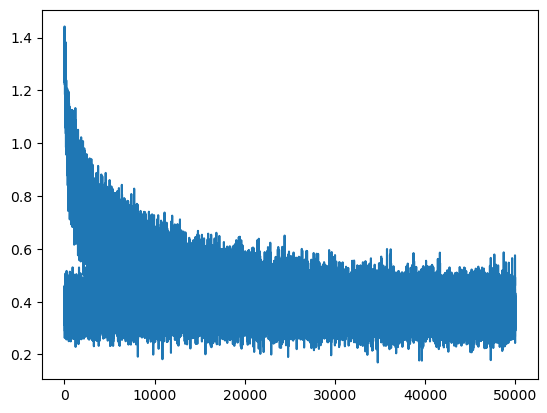

In [288]:
plt.plot(stepi, lossi)

In [299]:
# check the train set loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
nll = F.cross_entropy(logits, Ytr)
print(f'full training set nll: {nll}')

full training set nll: 2.200216293334961


In [300]:
# check the dev set loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
nll = F.cross_entropy(logits, Ydev)
print(f'full training set nll: {nll}')

full training set nll: 2.2286133766174316


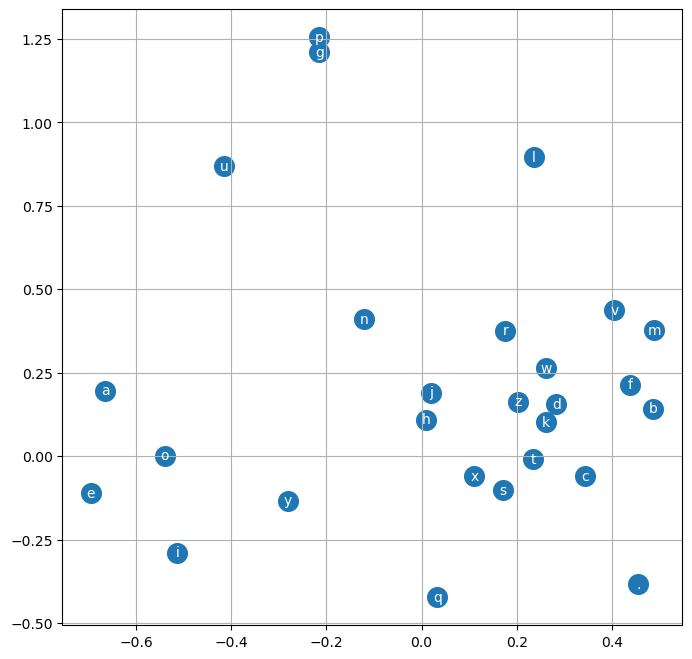

In [281]:
# plot the 2d embeddings
assert C.shape[1] == 2
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')

7.68198823928833


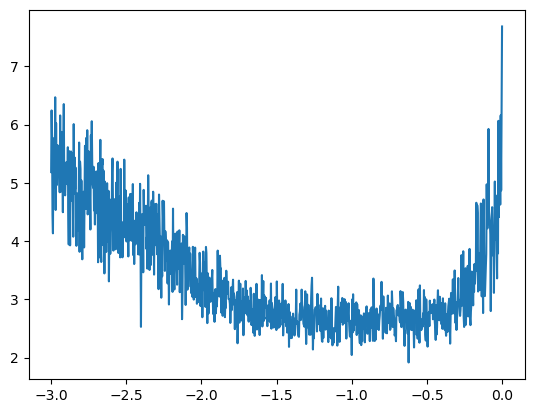

In [20]:
# How to determine the optimal learning rate
# plot loss against an incrementally increasing learning rate value

losses = []
lrs=[]
start = 1

learning_rates_exp = torch.linspace(-3, 0, 1000)
learning_rates = 10**learning_rates_exp

# train as before, but set learning rates and track loss
for p in parameters:
    p.requires_grad = True

batch_size = 32
for i in range(len(learning_rates)):
    # minibatch selection
    indices = torch.randint(0, X.shape[0], (batch_size,))
    X_batch = X[indices]
    Y_batch = Y[indices]
    
    # forward pass
    #assert torch.allclose(F.one_hot(X, num_classes=27).float() @ C, C[X])
    emb = C[X_batch]
    h1 = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h1 @ W2 + b2
    nll = F.cross_entropy(logits, Y_batch) # mean reduction by default
    # backward pass
    for p in parameters:
        p.grad = None  
        
    nll.backward()

    lr = learning_rates[i]
    for p in parameters:
        p.data +=  -lr * p.grad

    losses.append(nll.detach())
    lrs.append(lr)
print(nll.item())

plt.plot(learning_rates_exp, losses)
# plt.plot(x, y)


# This shows an exponenet of -1 (is 10**-1) is optimal for the learning rate
# since it is the bottom of the loss-lr curve

In [70]:
# But this might be overfitting - let's create train/dev/test splits
# train for model parameters
# dev used for hyperparameters
# test used for performance evaluation


def build_dataset(words):
    # words is a list of all words in dataset
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:]
            context.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'{X.shape=}, {Y.shape=}')
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train set
Xtr, Ytr = build_dataset(words[:n1])

# dev set 
Xdev, Ydev = build_dataset(words[n1:n2])

# test set
Xte, Yte = build_dataset(words[n2:])


X.shape=torch.Size([182580, 3]), Y.shape=torch.Size([182580])
X.shape=torch.Size([22740, 3]), Y.shape=torch.Size([22740])
X.shape=torch.Size([22826, 3]), Y.shape=torch.Size([22826])


In [62]:
len(words)


25626 28829
